<a href="https://colab.research.google.com/github/Manuelstv/Multiplos-a-es-/blob/main/multiplos_historicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Será que os múltiplos de uma ação (Preço/lucro, preço/receita,...) são informações relevantes ao se investir em ações no longo prazo? Nesse estudo, procuramos avaliar o retorno de uma carteira de ações em função de determinados múltiplos como o p/sr, p/l, p/vp. E examinar em quais momentos estamos propensos a ter retornos maiores.


Para isso foram utilizadas duas fontes de dados: Os dados dos demonstrativos financenciros disponibilizados publicamente pela CVM e dados das cotações das ações disponibilizadas pelo yahoo finance.

In [ ]:
!pip install wget
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import seaborn as sns
import random
from numpy import NaN
import plotly.graph_objs as go
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import wget
from zipfile import ZipFile

plt.rcParams['figure.figsize'] = (12.5,4.5)
plt.rcParams.update({'font.size': 10})

import warnings
warnings.filterwarnings('ignore')

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()

from scipy.stats import norm,t

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=2b171eee8217cc51df007266632739c4b59a7af592fb089065b73c726b443882
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 6.3 MB 43.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=e068e5675512a3b80260cbf46210e2cb5a071a394ff8f7d24a0ac975e4532b4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-gp3lb8is/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Acessando a base de dados e criando arquivos históricos

In [ ]:
url_base = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/'

* criando uma lista com o nome de todos os arquivos

In [ ]:
arquivos_zip = []
for ano in range(2011,2021+1):
  arquivos_zip.append(f'itr_cia_aberta_{ano}.zip')

arquivos_zip

['itr_cia_aberta_2011.zip',
 'itr_cia_aberta_2012.zip',
 'itr_cia_aberta_2013.zip',
 'itr_cia_aberta_2014.zip',
 'itr_cia_aberta_2015.zip',
 'itr_cia_aberta_2016.zip',
 'itr_cia_aberta_2017.zip',
 'itr_cia_aberta_2018.zip',
 'itr_cia_aberta_2019.zip',
 'itr_cia_aberta_2020.zip',
 'itr_cia_aberta_2021.zip']

* Fazendo o download de todos os arquivos

In [ ]:
for arq in arquivos_zip:
  wget.download(url_base+arq)

* Extraindo os arquivos zip

In [ ]:
for arq in arquivos_zip:
  ZipFile(arq, 'r').extractall('CVM')

* Concatenado arquivos históricos

In [ ]:
#nomes = ['BPA_con', 'BPA_ind', 'BPP_con', 'BPP_ind', 'DFC_MD_con', 'DFC_MD_ind', 'DFC_MI_con', 'DFC_MI_ind', 'DMPL_con', 'DMPL_ind', 'DRE_con', 'DRE_ind', 'DVA_con', 'DVA_ind']
nomes = ['DRE_ind', 'DMPL_ind']
for nome in nomes:
  arquivo = pd.DataFrame()
  #por ora filtrar até 2020, antes disso constatei indices duplicados
  for ano in range(2011,2020+1):
    arquivo = pd.concat([arquivo, pd.read_csv(f'CVM/itr_cia_aberta_{nome}_{ano}.csv', sep=';', decimal=',', encoding='ISO-8859-1')])

  arquivo.to_csv(f'itr_cia_aberta_{nome}_2011-2021.csv', index=False)



*   Selecionando demonstrações financeiras relevantes


In [ ]:
dre = pd.read_csv('/content/itr_cia_aberta_DRE_ind_2011-2021.csv')
dmpl = pd.read_csv('/content/itr_cia_aberta_DMPL_ind_2011-2021.csv')
dre.to_csv('dre.csv')
dmpl.to_csv('dmpl.csv')

In [ ]:
'''from google.colab import drive
drive.mount("/content/mdrive")
dre = pd.read_csv('/content/mdrive/My Drive/demonstrativos/dre.csv')
dmpl = pd.read_csv('/content/mdrive/My Drive/demonstrativos/dmpl.csv')'''

Drive already mounted at /content/mdrive; to attempt to forcibly remount, call drive.mount("/content/mdrive", force_remount=True).


FileNotFoundError: ignored

*   Função para coletar os dados de determinado demonstrativo financeiro de determinada empresa



In [ ]:
def filtro_empresa(demo, nome_cia):
  df = demo[demo.DENOM_CIA == nome_cia]
  df['DF_REFER'] = pd.to_datetime(df['DT_REFER'])
  df = df.set_index(df['DT_REFER'])
  df = df[df.ORDEM_EXERC == 'ÚLTIMO']
  df = df[['CD_CVM','DT_INI_EXERC','ORDEM_EXERC','DT_FIM_EXERC','CD_CONTA','DS_CONTA','VL_CONTA']]
  return df

*   Função que coleta os de fechamento dados do yahoo finance



In [ ]:
def cotacoes(start, end, ticker_cia, interval, nome_cia):
  ativo = pd.DataFrame()
  ativo[[nome_cia]] = yf.download(ticker_cia, start = start, end = end, interval = interval)[["Adj Close"]]
  return ativo

*   Função para calcular qualquer indicador da forma (preço de uma ação)/(alguma coisa). ex: preço_da_ação/lucro_total, preço_da_ação/receita_total... 



In [ ]:
def multiplo(df, name, ativo, nome_cia):
  ativo[name] = df['VL_CONTA']
  ativo = ativo.join(df, how='outer')
  ativo.fillna(method='ffill', inplace=True)
  ativo['preco/'+ name] = ativo[nome_cia]/ativo[name]
  return ativo[['preco/'+ name]]

*   Regressão linear


In [ ]:
def linear(X,y):
  from sklearn.metrics import r2_score
  regressor = LinearRegression()
  regressor.fit(X, y)
  y_pred = regressor.predict(X)
  r2 = r2_score(y, y_pred)
  return X,y_pred, r2

*   Regressão polinomial

In [ ]:
def poli(X,y,degree):
  X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
  degree=2
  polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
  polyreg.fit(X,y)
  y_pred = polyreg.predict(X_seq)
  return X_seq, y_pred

*   Função que coleta um dado(ex: receita) da dre. O argumento cd_conta é o códifo da conta como consta nos documentos da cvm.

In [ ]:
def coleta_conta(cd_conta, demo, soma_movel):
  df = demo[demo['CD_CONTA'] == cd_conta]
  df = df.drop_duplicates(subset=['DT_INI_EXERC'])
  df.index = pd.to_datetime(df.index)
  if (soma_movel == True):
    #Cálculo da soma movel(4 periodos = 4 trimestres = 1 ano) do dado 
    df['VL_CONTA'] = df[['VL_CONTA']].rolling(4).sum()
  df.dropna(inplace=True)
  return df

In [ ]:
nome_cias = []
for col in dre[['DENOM_CIA']]:
  nome_cias.append(dre[['DENOM_CIA']][col].unique())

np.set_printoptions(threshold=np.inf)
nome_cias

[array(['BCO BRASIL S.A.', 'BRB BCO DE BRASILIA S.A.',
        'CENTRAIS ELET BRAS S.A. - ELETROBRAS',
        'CIA ENERGETICA DE BRASILIA', 'VBC ENERGIA SA',
        'NET SERVIÇOS DE COMUNICAÇÃO S.A.', 'SHOPPING CENTER TACARUNA SA',
        'PARCOM PARTICIPACOES S.A. - EM LIQUIDAÇÃO',
        'NEUMARKT TRADE AND FINANCIAL CENTER S/A',
        'FORPART S.A. - EM LIQUIDAÇÃO', 'BOMBRIL HOLDING SA', 'CIMS S.A.',
        'TELEC BRASILEIRAS S.A. TELEBRAS',
        'KOSMOS COMÉRCIO DE VESTUÁRIO S/A - EM RECUPERAÇÃO JUDICIAL',
        'ATOM EMPREENDIMENTOS E PARTICIPAÇÕES S.A.',
        'BNDES PARTICIPACOES S.A. - BNDESPAR', 'ELETRON S.A.',
        'SERRA AZUL WATER PARK SA', 'STATKRAFT ENERGIAS RENOVAVEIS S.A.',
        'INVESTCO S.A.', 'GTD PARTICIPACOES SA',
        'LITEL PARTICIPACOES S.A.', 'AMERICANAS S.A.',
        'CONC RODOVIA PRES. DUTRA S.A.', 'ENERGISA S.A.', 'SAUIPE SA',
        'SANTA CATARINA PART INVEST SA', 'FERROVIA CENTRO-ATLANTICA S.A.',
        'HOPI HARI SA', 'CONC RIO-

In [ ]:
#df['LOJAS RENNER S.A.'+'_preco/receita'] = multiplo(df = df_receita, name = 'receita', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
#print(df_receita['VL_CONTA'])
#print(df['LOJAS RENNER S.A.'])
a = df_receita['VL_CONTA']
a[a.index.duplicated()]

DT_REFER
2021-03-31    3089960.0
Name: VL_CONTA, dtype: float64

*   Coletar (e calcular) os dados de cada empresa e armazenar tudo em um dataframe



In [ ]:
tickers_cias = ['BBAS3.sa', 'PETR3.SA', 'LREN3.SA', 'LAME4.SA', 'VIVT3.SA','CGRA4.SA']
nomes_cias = ['BCO BRASIL S.A.', 'PETROLEO BRASILEIRO S.A. PETROBRAS', 'LOJAS RENNER S.A.', 'LOJAS AMERICANAS S.A.','VIVO PARTICIPAÇÕES SA', 'GRAZZIOTIN S.A.'] 

numero_empresas = len(nomes_cias)
#Variavel que servira como o prazo que será analisado. É o número de dias para o qual o retorno acumulado será calculado.
#É esperado que quando o prazo é muito baixo, não existe padrão.
#Para períodos muito altos, ficamos com uma amostra pequena demais, o que impossibilita tirar qualquer conclusão.
anos = 3.
#1 ano são aproximadamente 252 dias de negociação na bolsa
window = int(anos*252)

df = pd.DataFrame()
#loop sobre todas empresas
for i in range (0, numero_empresas):

  #importando a informação dos demonstrativos financeiros de cada empresa
  dre_df = filtro_empresa(demo = dre, nome_cia = nomes_cias[i])
  dmpl_df = filtro_empresa(demo = dmpl, nome_cia = nomes_cias[i])  
  
  #coluna 0 (cotacoes de cada ativo)
  df[[nomes_cias[i]]] = cotacoes(start = '2010-01-01', end = '2021-01-01', ticker_cia=tickers_cias[i], interval='1d', nome_cia = nomes_cias[i])

  #coletando os dados relevantes de cada demonstrativo
  df_receita = coleta_conta(cd_conta = '3.01', demo = dre_df, soma_movel= True)
  df_pat_liq = coleta_conta(cd_conta = '5.01', demo = dmpl_df, soma_movel=False)
  df_ebit = coleta_conta(cd_conta = '3.05', demo = dre_df, soma_movel = True)
  df_lpa = coleta_conta(cd_conta = '3.99.01.01', demo = dre_df, soma_movel = False)
  df_lucro = coleta_conta(cd_conta = '3.11', demo = dre_df, soma_movel = False)
  #wtf?
  df_lpa = df_lpa.iloc[1:]
  
  #coluna 1(retorno diario)
  df[nomes_cias[i]+'_retorno'] = df[nomes_cias[i]].pct_change()
  
  #coluna 2(retorno acumulado que dará nos proximos n dias, sendo n = window)
  df[nomes_cias[i]+'_retorno_acumulado'] = (1+df[nomes_cias[i]+'_retorno']).shift(-window).rolling(window).apply(np.prod)
  
  #coluna 3(preço da ação/ receita total)
  df[nomes_cias[i]+'_preco/receita'] = multiplo(df = df_receita, name = 'receita', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  #coluna 4(preço da ação/patrimonio liquido total)
  df[nomes_cias[i]+'_preco/pat_liq'] = multiplo(df = df_pat_liq, name = 'pat_liq', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  #coluna 5(preço da ação/ebit total)
  df[nomes_cias[i]+'_preco/ebit'] = multiplo(df = df_ebit, name = 'ebit', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])

  #coluna 6(roe)
  #print(df[df.index.duplicated()])
  df[nomes_cias[i]+'_roe'] = (df_lucro['VL_CONTA']/df_receita['VL_CONTA'])
  df[nomes_cias[i]+'_roe'].fillna(method='ffill', inplace=True)

  #coluna 7 (preco/lucro)
  df[nomes_cias[i]+'_preco/lpa'] = multiplo(df = df_lpa, name = 'lpa', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  df[df.index.duplicated()]

  #coluna 8
  df[nomes_cias[i]+'_retorno_acumulado_ltm'] = (1+df[nomes_cias[i]+'_retorno']).shift(2*252).rolling(2*252).apply(np.prod)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


*   Calculando os dados pela carteira formada pelas ações selecionadas previamente


In [ ]:
numero_colunas = len(df.columns)
step = numero_colunas/numero_empresas

#Definição da variavel carteira, que ira armazenar os dados relevantes do agregado de ações
carteira = pd.DataFrame()
#Calculamos a média de cada coluna, na pratica isso significa uma distribuição com pesos iguais para cada ativo(1/n)
carteira['retorno_acumulado'] = df.iloc[:,np.arange(2,df.shape[1],step = step)].mean(axis=1)
carteira['preco/receita'] = df.iloc[:,np.arange(3,df.shape[1],step = step)].mean(axis=1)
carteira['preco/pat_liq'] = df.iloc[:,np.arange(4,df.shape[1],step = step)].mean(axis=1)
carteira['preco/ebit'] = df.iloc[:,np.arange(5,df.shape[1],step = step)].mean(axis=1)
carteira['roe'] = df.iloc[:,np.arange(6,df.shape[1],step = step)].mean(axis=1)
carteira['preco/lpa'] = df.iloc[:,np.arange(7,df.shape[1],step = step)].mean(axis=1)
carteira['retorno'] = df.iloc[:,np.arange(1,df.shape[1],step = step)].mean(axis=1)
carteira['retorno_var'] = carteira['retorno'].shift(252).rolling(252).var()
carteira['retorno_acumulado_ltm'] = df.iloc[:,np.arange(8,df.shape[1],step = step)].mean(axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Normalização dos multiplos
value = pd.DataFrame()
value['retorno_acumulado_anualizado'] = carteira['retorno_acumulado']**(1/anos)

value['std_preco/pat_liq'] = MinMaxScaler().fit_transform(carteira[['preco/pat_liq']]) 
value['std_preco/ebit'] = MinMaxScaler().fit_transform(carteira[['preco/ebit']])
value['std_preco/receita'] = MinMaxScaler().fit_transform(carteira[['preco/receita']])
value['retorno_var'] = carteira['retorno_var']
value['retorno_acumulado_ltm'] = carteira['retorno_acumulado_ltm']
#Definição indicador que benjamin graham usava 22,5*sqrt((p/l)*(p/vp))
carteira['graham'] = (carteira['preco/receita']*carteira['preco/pat_liq']*carteira['preco/ebit'])**1/3
value['std_graham'] = MinMaxScaler().fit_transform(carteira[['graham']])

a = value
last = value.iloc[-1]
value.dropna(inplace =True)

In [ ]:
X = value.iloc[:, 1:5].values
y = value.iloc[:, 0].values

from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 0)
from sklearn import tree
from sklearn.tree import export, DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=6)
regressor.fit(X_treinamento, y_treinamento)
score = regressor.score(X_treinamento, y_treinamento)

previsoes = regressor.predict(X_teste)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste, previsoes)

print("score: {} \n".format(regressor.score(X_teste, y_teste)))
print('MAE: {} \n'.format(mae))
print(regressor.feature_importances_,"\n")

score: 0.9227552144372663 

MAE: 0.016503042068082226 

[0.0246023  0.41800031 0.08396823 0.47342916] 



In [ ]:
print("{}\n".format(last))
print("resultado previsto para :{}".format(regressor.predict([[last['std_preco/pat_liq'],last['std_preco/ebit'], last['std_preco/receita'], last['std_graham']]])))

retorno_acumulado_anualizado         NaN
std_preco/pat_liq               0.101966
std_preco/ebit                  0.922054
std_preco/receita               0.910988
retorno_var                     0.000140
retorno_acumulado_ltm           1.560476
std_graham                      0.335285
Name: 2020-12-30 00:00:00, dtype: float64

resultado previsto para :[1.11056578]


In [ ]:
export.export_graphviz(regressor,
                       out_file = 'arvore.dot',
                       feature_names = ['std_preco/pat_liq', 'std_preco/ebit', 'std_preco/receita', 'std_graham'],
                       class_names = regressor.classes_,
                       filled = True,
                       leaves_parallel=True)

*   Plot dos gráficos




963


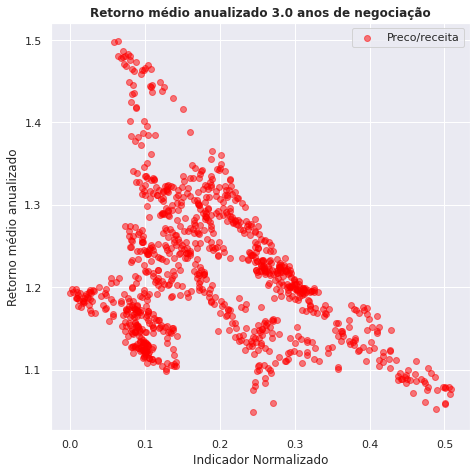

In [ ]:
sns.set()
fig, axs = plt.subplots(figsize=(7.5,7.5), facecolor='w', edgecolor='k')

#definições para fazer a regressão polinimial/linear
my_df = value[['std_preco/receita','retorno_acumulado_anualizado']].dropna()
X = pd.DataFrame(my_df.iloc[:,0])
y = pd.DataFrame(my_df.iloc[:,1])

#Regressão linear
#X,y_pred, r2 = linear(X,y)
#axs.plot(X, y_pred, color = 'blue', label="r^2 = {}".format(r2))
  
#Regressao polinomial
#X_seq,y_pred2 = poli(X,y,degree = 3)
#axs.plot(X_seq,y_pred2,color="black")

#plots
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/lpa'], marker='o', color='green', label = 'preco/lucro', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/ebit'], marker='o', color='blue', label = 'preco/ebit',alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/pat_liq'], marker='o', color='green', label = 'Preco/pat_liq', alpha =0.5)
axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/receita'], marker='o', color='red', label = 'Preco/receita', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_graham'], marker='o', color='red', label = 'Graham', alpha =0.5)

#axs.axvline(x=last['std_preco/receita'],label = "Nivel atual", color = 'red', alpha=0.5)
#axs.axvline(x=last['std_preco/pat_liq'],label = "Nivel atual", color = 'green', alpha =0.5)
#axs.axvline(x=last['std_preco/ebit'],label = "Nivel atual", color = 'blue', alpha=0.5)


#legendas  
axs.set_title('Retorno médio anualizado {} anos de negociação'.format(anos), fontsize=12, fontweight ="bold")
axs.set_xlabel("Indicador Normalizado")
axs.set_ylabel("Retorno médio anualizado")
axs.legend()

axs=axs

print(value['retorno_acumulado_anualizado'].size)

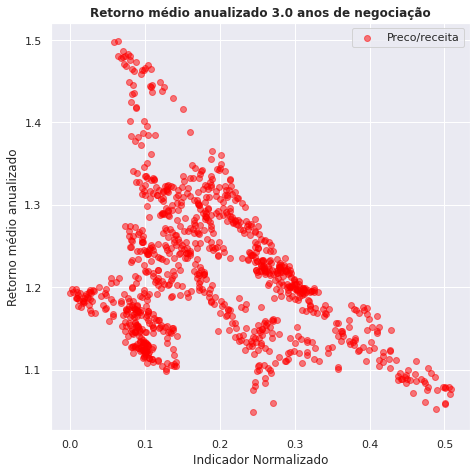

In [ ]:
sns.set()
fig, axs = plt.subplots(figsize=(7.5,7.5), facecolor='w', edgecolor='k')

#definições para fazer a regressão polinimial/linear
my_df = value[['std_preco/pat_liq','retorno_acumulado_anualizado']].dropna()
X = pd.DataFrame(my_df.iloc[:,0])
y = pd.DataFrame(my_df.iloc[:,1])

'''
#Regressão linear
X,y_pred, r2 = linear(X,y)
axs.plot(X, y_pred, color = 'blue', label="r^2 = {}".format(r2))
  
#Regressao polinomial
X_seq,y_pred2 = poli(X,y,degree = 3)
axs.plot(X_seq,y_pred2,color="black")'''

#plots
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/lpa'], marker='o', color='green', label = 'preco/lucro', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/ebit'], marker='o', color='blue', label = 'preco/ebit',alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/pat_liq'], marker='o', color='green', label = 'Preco/pat_liq', alpha =0.5)
axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/receita'], marker='o', color='red', label = 'Preco/receita', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_graham'], marker='o', color='red', label = 'Graham', alpha =0.5)

#axs.axvline(x=last['std_preco/receita'],label = "Nivel atual", color = 'red', alpha=0.5)
#axs.axvline(x=carteira['std_preco/pat_liq'].iloc[-1],label = "Nivel atual", color = 'green', alpha =0.5)
#axs.axvline(x=last['std_preco/ebit'],label = "Nivel atual", color = 'blue', alpha=0.5)


#legendas  
axs.set_title('Retorno médio anualizado {} anos de negociação'.format(anos), fontsize=12, fontweight ="bold")
axs.set_xlabel("Indicador Normalizado")
axs.set_ylabel("Retorno médio anualizado")
axs.legend()

axs=axs

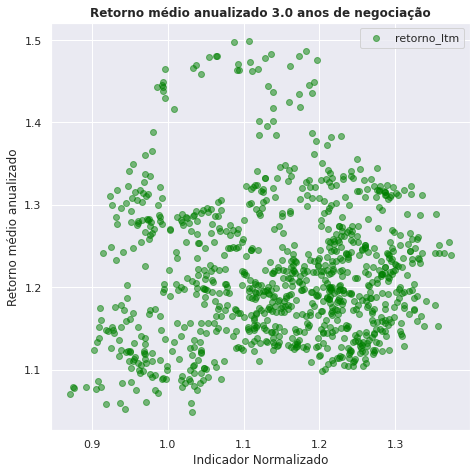

In [ ]:
sns.set()
fig, axs = plt.subplots(figsize=(7.5,7.5), facecolor='w', edgecolor='k')

#plots
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/lpa'], marker='o', color='green', label = 'preco/lucro', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = carteira['std_preco/ebit'], marker='o', color='blue', label = 'preco/ebit',alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['retorno_var'], marker='o', color='green', label = 'Preco/pat_liq', alpha =0.5)
axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['retorno_acumulado_ltm'], marker='o', color='green', label = 'retorno_ltm', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/receita'], marker='o', color='red', label = 'Preco/receita', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_graham'], marker='o', color='red', label = 'Graham', alpha =0.5)

#axs.axvline(x=last['std_preco/receita'],label = "Nivel atual", color = 'red', alpha=0.5)
#axs.axvline(x=carteira['std_preco/pat_liq'].iloc[-1],label = "Nivel atual", color = 'green', alpha =0.5)
#axs.axvline(x=last['std_preco/ebit'],label = "Nivel atual", color = 'blue', alpha=0.5)


#legendas  
axs.set_title('Retorno médio anualizado {} anos de negociação'.format(anos), fontsize=12, fontweight ="bold")
axs.set_xlabel("Indicador Normalizado")
axs.set_ylabel("Retorno médio anualizado")
axs.legend()

axs=axs

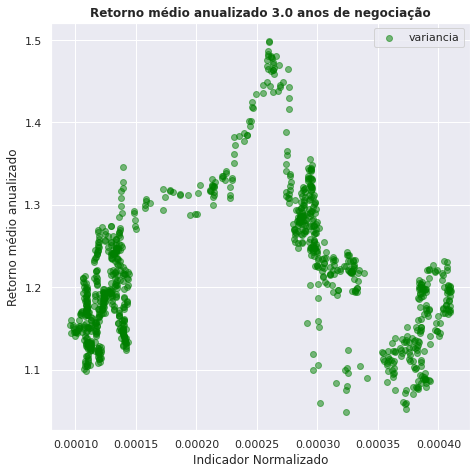

In [ ]:
sns.set()
fig, axs = plt.subplots(figsize=(7.5,7.5), facecolor='w', edgecolor='k')

#plots
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/lpa'], marker='o', color='green', label = 'preco/lucro', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = carteira['std_preco/ebit'], marker='o', color='blue', label = 'preco/ebit',alpha =0.5)
axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['retorno_var'], marker='o', color='green', label = 'variancia', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['retorno_acumulado_ltm'], marker='o', color='green', label = 'Preco/retorno_ltm', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_preco/receita'], marker='o', color='red', label = 'Preco/receita', alpha =0.5)
#axs.scatter(y = value['retorno_acumulado_anualizado'],x = value['std_graham'], marker='o', color='red', label = 'Graham', alpha =0.5)

#axs.axvline(x=last['std_preco/receita'],label = "Nivel atual", color = 'red', alpha=0.5)
#axs.axvline(x=carteira['std_preco/pat_liq'].iloc[-1],label = "Nivel atual", color = 'green', alpha =0.5)
#axs.axvline(x=last['std_preco/ebit'],label = "Nivel atual", color = 'blue', alpha=0.5)


#legendas  
axs.set_title('Retorno médio anualizado {} anos de negociação'.format(anos), fontsize=12, fontweight ="bold")
axs.set_xlabel("Indicador Normalizado")
axs.set_ylabel("Retorno médio anualizado")
axs.legend()

axs=axs

In [ ]:
carteira.to_csv('carteira.csv')